## Perth Loop to Flopy

In [66]:
# external imports
import pandas as pd

#import rasterio
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy


%load_ext autoreload
%autoreload 2

import loopflopy
print(loopflopy.__file__)

import pkgutil
def list_modules(package):
    package_path = package.__path__
    modules = [name for _, name, _ in pkgutil.iter_modules(package_path)]
    return modules

modules = list_modules(loopflopy)
for module in modules: print(module)

def print_object_details(obj):
    all_attributes_methods = dir(obj)
    methods = [attr for attr in all_attributes_methods if callable(getattr(obj, attr)) and not attr.startswith("__")]
    variables = [attr for attr in all_attributes_methods if not callable(getattr(obj, attr)) and not attr.startswith("__")]

    print('Methods:')
    for method in methods: print(method)
    print("\nVariables")
    for variable in variables: print(variable)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\users\00105295\projects\loopflopy\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel_routines
mesh
mesh_routines
modelling_routines
observations
project
spatial
spatial_routines
structuralmodel


### 1. Setup Project

In [67]:
name = 'perth'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe)

### 2. Spatial Processing

In [68]:
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape
from loopflopy.spatial import Spatial

spatial = Spatial(epsg = 28350)

371803.12087969296 6504002.68331732
415000.0 6504000.0
371803.12087969296 6504002.68331732


c:\Users\00105295\Projects\Perth_geo_model\scripts\process_spatial.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Leed1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  faults_gdf.loc[int(1), "id"]  = 'Leed1'


Removing faults nodes on  Biggestmeanest  because too close to boundary:  [<POINT (368502.338 6542891.002)>, <POINT (367914.631 6543697.901)>]


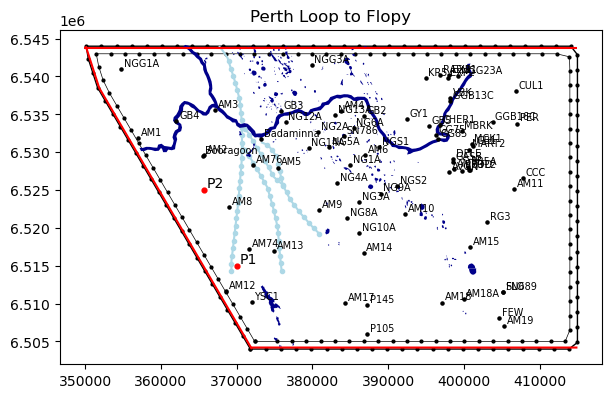

In [69]:
import process_spatial
process_spatial.make_bbox_shp(spatial, x0 = 348000, x1 = 415000, y0 = 6504000, y1 = 6544000)
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 1000, node_spacing = 2000)
process_spatial.obs_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)
process_spatial.lakes(spatial)
process_spatial.river(spatial, node_spacing = 500, buffer_distance = 200, threshold = 100)
process_spatial.plot_spatial(spatial)


In [70]:
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
spatial.faults_gdf.explore(m=m, color = 'red')

### 3. Structural Model

In [71]:

# ------------------------------------------------------
geodata_fname = '../data/data_dwer/geology.xls'
data_sheetname = 'bore_info'
strat_sheetname = 'strat_info'
bbox = [(343000, 6483000, -3000), (408000, 6564000, 500)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structuralmodel 
process_structuralmodel.prepare_strat_column(structuralmodel)
process_structuralmodel.prepare_geodata(structuralmodel, Lleyland = False, Brett = True)
process_structuralmodel.create_structuralmodel(structuralmodel)




c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [72]:
labels = structuralmodel.strat_names[1:]
a = np.arange(-1,len(labels),1)+0.5
a

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5])

(9600,) (9600,) (9600,)
(9600,) (9600,) (9600,)
(9600,) (9600,) (9600,)
(9600,) (9600,) (9600,)


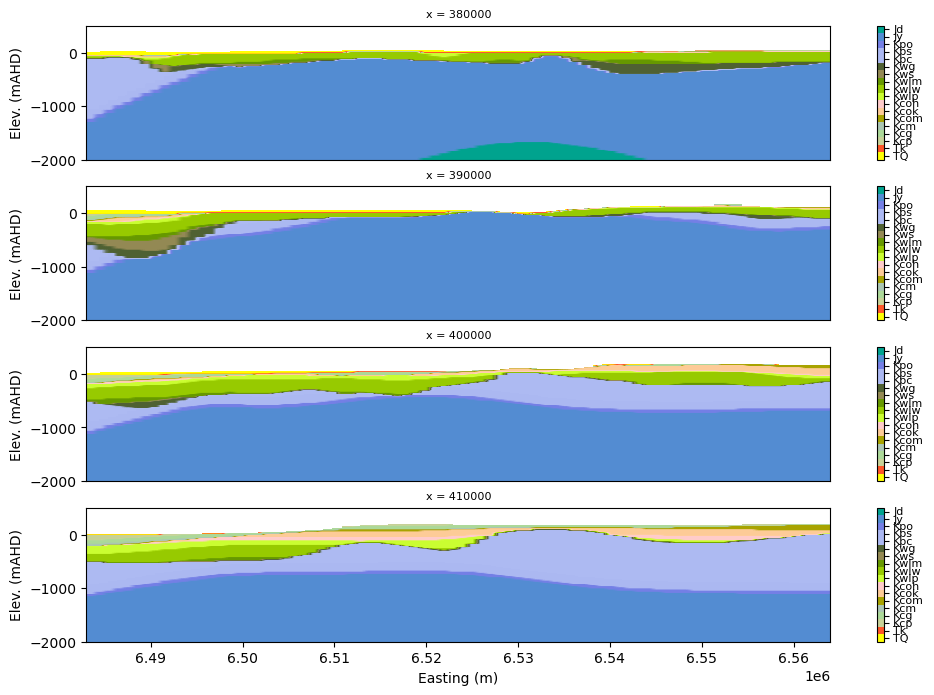

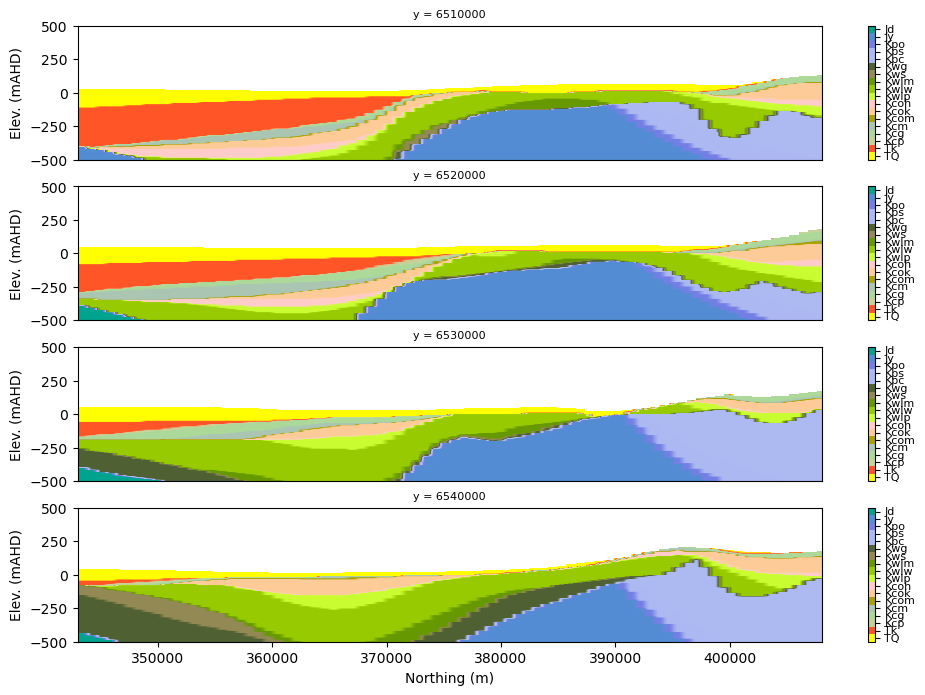

In [73]:
transect_x = [380000, 390000, 400000, 410000]
transect_y = [6510000, 6520000, 6530000, 6540000]
structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 120, x1 = 6520000, z0 = -2000) 
structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 120, z0 = -500) 

#structuralmodel.strat 
#structuralmodel.strat_col 
#structuralmodel.strat_names 
#structuralmodel.cmap
#structuralmodel.norm 
#structuralmodel.data

### 4. Contour around surface lithology

Max ground level =  260.91
Min ground level =  -43.6
No special cells
350124.40660379577 6504000.069846243
number of cells in plan =  2000
   Creating Geomodel (lithology and discretisation arrays) for  surf_lith  ...
Time taken =  22.286324


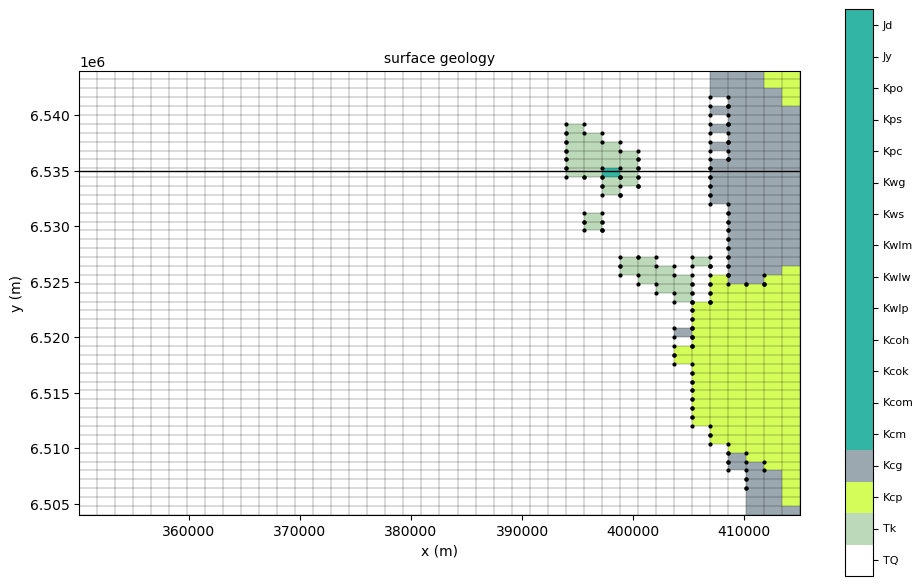

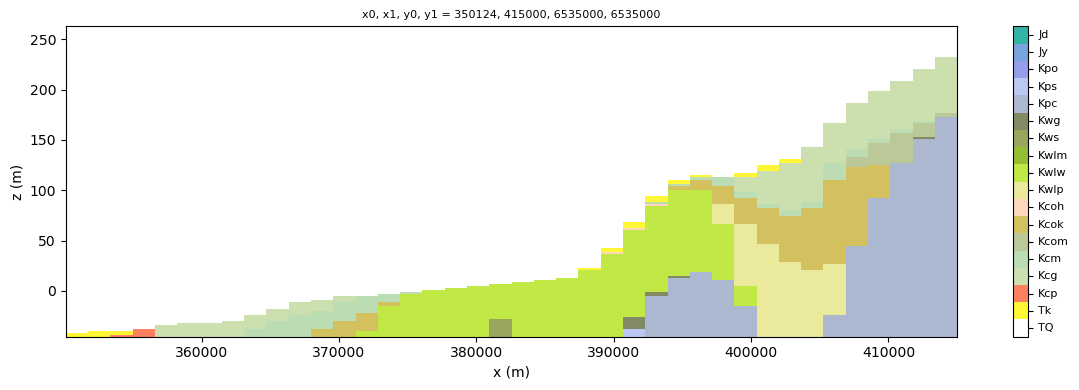

In [87]:
# Pick max and min ground levels
ground_entries = structuralmodel.data[structuralmodel.data['lithcode'] == 'Ground']
max_gl, min_gl = max(ground_entries.Z), min(ground_entries.Z)
print('Max ground level = ', max_gl)
print('Min ground level = ', min_gl)
z0, z1 = min_gl-2, max_gl+2

# Create a structured mesh to detect lithological interfaces
from loopflopy.mesh import Mesh
mesh = Mesh(plangrid = 'car') 
mesh.ncol, mesh.nrow = 40, 50
mesh.create_mesh(project, spatial)
print('number of cells in plan = ', mesh.ncpl)

# Create a geomodel (near surface) to be able to find surface lithology
scenario = 'surf_lith'
vertgrid = 'con'    # 'vox', 'con' or 'con2'
from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 1, res = 2)#, max_thick = 100. * np.ones((7)))

geomodel.create_lith_dis_arrays(mesh, structuralmodel)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)
geomodel.get_surface_lith()

# Add refinement nodes at surface lithoogy interface
raster = geomodel.surf_lith.reshape((mesh.nrow, mesh.ncol))

# Function to find interfaces and generate nodes
def generate_interface_nodes(raster):
    rows, cols = mesh.nrow, mesh.ncol#raster.shape
    nodes = []

    for i in range(rows - 1):
        for j in range(cols - 1):
            if raster[i, j] != raster[i, j + 1]:
                node = Point(mesh.xcenters[j] + 0.5 * mesh.delx, mesh.ycenters[i] - 0.5 * mesh.dely)
                if node.within(spatial.model_boundary_poly.buffer(-2 * spatial.boundary_buff)): # So that no nodes too close to model boundary 
                    nodes.append(node)
            if raster[i, j] != raster[i + 1, j]:
                node = Point(mesh.xcenters[j] + 0.5 * mesh.delx, mesh.ycenters[i] - 0.5 * mesh.dely)
                if node.within(spatial.model_boundary_poly.buffer(-2 * spatial.boundary_buff)): # So that no nodes too close to model boundary 
                    nodes.append(node)
            if raster[i, j] != raster[i + 1, j + 1]:
                node = Point(mesh.xcenters[j] + 0.5 * mesh.delx, mesh.ycenters[i] - 0.5 * mesh.dely)
                if node.within(spatial.model_boundary_poly.buffer(-2 * spatial.boundary_buff)): # So that no nodes too close to model boundary 
                    nodes.append(node)

    return nodes

nodes = generate_interface_nodes(raster) # Generate nodes at the interfaces
gdf = gpd.GeoDataFrame(crs = spatial.epsg, geometry=nodes) # Create a GeoDataFrame from the nodes
#gdf.crs = spatial.crs
gdf.to_file("../modelfiles/interface_nodes.shp") # Save the nodes as a shapefile
spatial.interface_nodes = list(zip(gdf.geometry.x, gdf.geometry.y)) # Save the nodes as a list of tuples


geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel, y0 = 6535000, y1 = 6535000)
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0 = 6535000, y1 = 6535000)#, z0 = -900, z1 = -2000) 

### 4. Meshing

In [88]:
from loopflopy.mesh import Mesh
special_cells = {'chd': ['west'], 
                 'ghb': ['north', 'south'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], 
                 'poly': ['river']}
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [89]:
mesh.modelmaxtri = 2000000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 50 # 200 radius of inner circle around pumping bores
mesh.radius2 = 200 # 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['faults_nodes', 'bore_refinement_nodes', 'interface_nodes', 'river_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)


faults_nodes
bore_refinement_nodes
interface_nodes
river_nodes
number of cells in plan =  4696


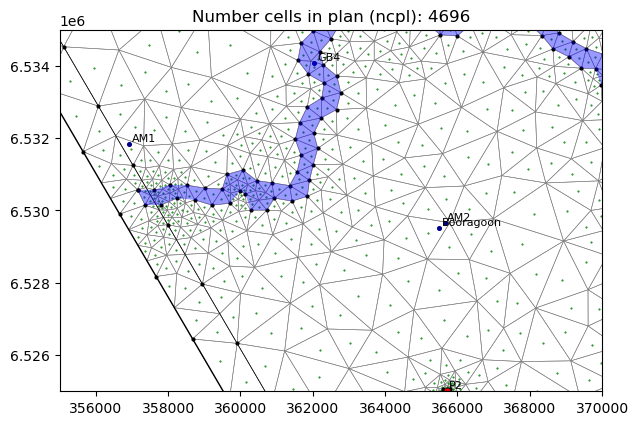

In [90]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

xlim = [355000, 370000]
ylim = [6525000, 6535000]

features = ['wel', 'obs', 'fault','river']
mesh.plot_cell2d(spatial, features, xlim, ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['west']
Group =  ghb ['north', 'south']
Group =  wel ['pumpbores']
Group =  obs ['obsbores']
Group =  poly ['river']


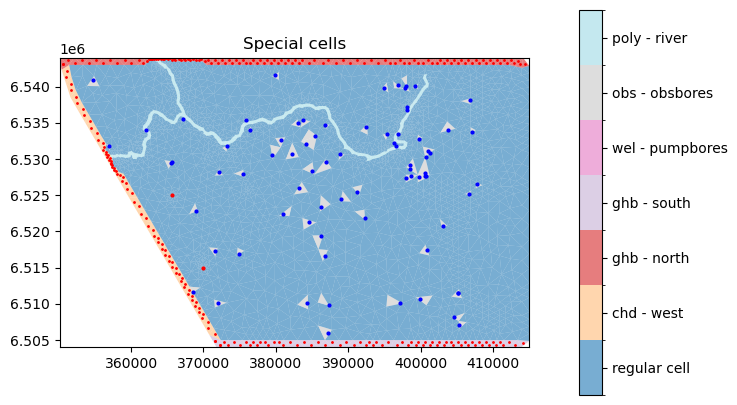

In [91]:
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### 5. Geomodel

In [92]:
# voxel: nlay, z0, z1
# con:   nls, res
# con2:  nls, res, max_thick

scenario = 's1'
vertgrid = 'con'    # 'vox', 'con' or 'con2'
z0, z1 = -1500, 200

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 2)#, max_thick = 100. * np.ones((7)))

geomodel.create_lith_dis_arrays(mesh, structuralmodel)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)
geomodel.get_surface_lith()

   Creating Geomodel (lithology and discretisation arrays) for  s1  ...
Time taken =  232.221819


In [93]:
print(geomodel.lith_disv[:,30])
print(geomodel.top_geo[30])
print(geomodel.botm_geo[:,30])
print(geomodel.botm[:,30])

[ 0.  0.  1.  1.  2.  2.  3.  3.  4.  4.  5.  5.  6.  6.  7.  7.  8.  8.
  9.  9. 10. 10. 11. 11. 12. 12. 13. 13. 14. 14. 15. 15. 16. 16. 17. 17.]
46.0
[  -38.   -94.   -94.  -144.  -178.  -178.  -258.  -282.  -346.  -568.
  -568.  -606.  -606.  -606.  -606.  -606.  -694. -1500.]
[    4.   -38.   -66.   -94.   -94.   -94.  -119.  -144.  -161.  -178.
  -178.  -178.  -218.  -258.  -270.  -282.  -314.  -346.  -457.  -568.
  -568.  -568.  -587.  -606.  -606.  -606.  -606.  -606.  -606.  -606.
  -606.  -606.  -650.  -694. -1097. -1500.]


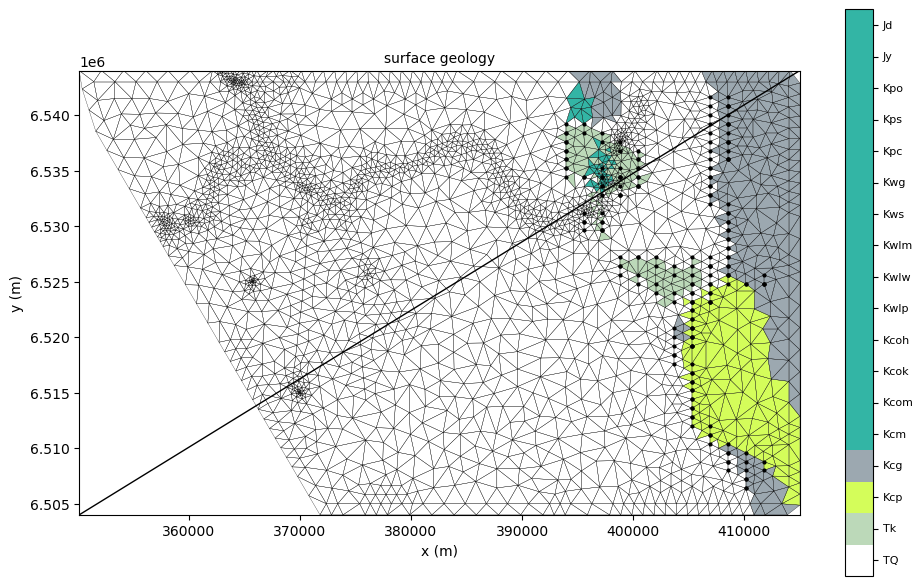

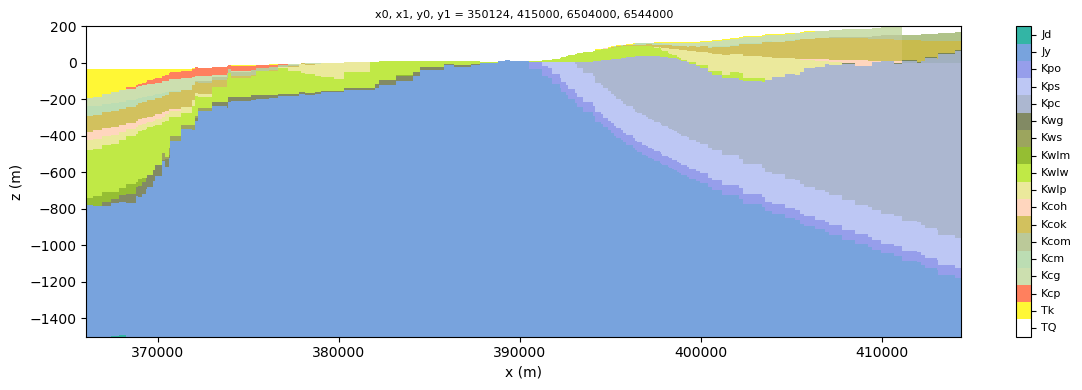

In [94]:
geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel)
geomodel.geomodel_transect_lith(structuralmodel, spatial)#, z0 = -900, z1 = -2000) 

In [84]:
print(np.unique(geomodel.idomain_geo, return_counts = True))
print(np.unique(geomodel.idomain, return_counts = True))

(array([0., 1.]), array([62975, 56563]))
(array([-1,  1]), array([125950, 113126]))


In [85]:
# FILL CELL PROPERTIES

geomodel.hk_perlay = 10. * np.ones((geomodel.nlg))  #[1., 1., 0.5, 0.1, 0.2, 5., 10.]
geomodel.vk_perlay = 1. * np.ones((geomodel.nlg)) 
geomodel.ss_perlay = 0.00001 * np.ones((geomodel.nlg)) 
geomodel.sy_perlay = 0.1 * np.ones((geomodel.nlg)) 

geomodel.fill_cell_properties(mesh)


   Filling cell properties for  s1  ...
Time taken =  0.127201


### 6. Prepare Data for Flowmodel

In [21]:
from process_data import Data
data = Data()

data.process_ic(geomodel, mesh)
data.process_rch(mesh)
data.process_chd(geomodel, mesh)

wel_q = [-0, -0]
wel_qlay= [5, 2]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)


78
31
[(np.float64(-192.0), np.float64(-192.0)), (np.float64(-92.0), np.float64(-92.0))]


### 7. Prepare Observations

In [ ]:
#import process_observations
#process_observations.load_data(path, sheetname)

In [64]:
# Import observation bores screened in Leederville or Yarragadee
raw_df = pd.read_excel('../data/data_dwer/obs/obs_bores.xlsx', sheet_name='Aquifers')

def filter_data(raw_df):
    # Filter data for Leederville and Yarragadee
    df = raw_df[(raw_df['Aquifer Name'] == 'Perth-Yarragadee North') | (raw_df['Aquifer Name'] == 'Perth-Leederville')]

    # Add Site Short Name to main df
    details = pd.read_excel('../data/data_dwer/obs/obs_bores.xlsx', sheet_name='Site Details')
    df = pd.merge(df, details[['Site Ref', 'Site Short Name']], on='Site Ref', how='left')

    # Import screen details
    casing = pd.read_excel('../data/data_dwer/obs/obs_bores.xlsx', sheet_name='Casing')
    casing = casing[casing['Element'] == 'Inlet (screen)']

    # Identify wells with multiple screen intervals and remove from df
    duplicates = casing[casing.duplicated('Site Ref', keep=False)]
    duplicates = pd.merge(duplicates, details[['Site Ref', 'Site Short Name']], on='Site Ref', how='left')
    duplicate_site_refs = duplicates['Site Ref'].unique()
    df_cleaned = df[~df['Site Ref'].isin(duplicate_site_refs)]

    # Add screened interval to df
    df_cleaned = pd.merge(df_cleaned, casing[['Site Ref', 'From (mbGL)', 'To (mbGL)', 'Inside Dia. (mm)']], on='Site Ref', how='left')

    # Export desired obs bores as csv
    df_cleaned.to_csv('../data/data_dwer/obs/cleaned_obs_bores.csv', index=False)

    # Use df_cleaned for data request on Water Information Reporting
    return df_cleaned

df_cleaned = filter_data(raw_df)

In [63]:
# Add GL to main df
measurements = pd.read_excel('../data/data_dwer/obs/obs_bores.xlsx', sheet_name='Depth Measurement Points')
ground_level = measurements[measurements['Measurement Point Type'] == 'Ground level'].drop_duplicates(subset=['Site Ref'])
toc = measurements[measurements['Measurement Point Type'] == 'Top of casing'].drop_duplicates(subset=['Site Ref'])
mp = measurements[measurements['Measurement Point Type'] == 'Measurement Point'].drop_duplicates(subset=['Site Ref'])

# First use groundlevel measurement
df = pd.merge(df_cleaned, ground_level[['Site Ref', 'Measurement Point Type', 'Elevation (m as per Datum Plane)']], on='Site Ref', how='left')
df = df.rename(columns={'Elevation (m as per Datum Plane)': 'GL mAHD'})
df = df.rename(columns={'Measurement Point Type': 'GL source'})

# If no groundlevel, then Top of Casing - 700mm for ground level
df = pd.merge(df, toc[['Site Ref', 'Measurement Point Type', 'Elevation (m as per Datum Plane)']], on='Site Ref', how='left')
df.loc[df['GL mAHD'].isna(), 'GL source'] = 'Top of casing'
df.loc[df['GL mAHD'].isna(), 'GL mAHD'] = df['Elevation (m as per Datum Plane)'] - 0.7
df = df.drop(columns=['Elevation (m as per Datum Plane)'])
df = df.drop(columns=['Measurement Point Type'])

# If no groundlevel or Top of Casing, use measurement point
df = pd.merge(df, mp[['Site Ref', 'Measurement Point Type', 'Elevation (m as per Datum Plane)']], on='Site Ref', how='left')
df.loc[df['GL mAHD'].isna(), 'GL source'] = 'Measurement Point'
df.loc[df['GL mAHD'].isna(), 'GL mAHD'] = df['Elevation (m as per Datum Plane)'] - 0.7
df = df.drop(columns=['Elevation (m as per Datum Plane)'])
df = df.drop(columns=['Measurement Point Type'])
df = df.drop(columns=['Comments'])
df = df.drop(columns=['Depth From/To (mbGL)'])

# Get top and bottom of screen in mAHD
df['Screen top'] = df['GL mAHD'] - df['From (mbGL)']
df['Screen bot'] = df['GL mAHD'] - df['To (mbGL)']
df['zobs'] = df['Screen bot'] + (df['Screen top'] - df['Screen bot'])/2
df

,Site Ref,Aquifer Name,Site Short Name,From (mbGL),To (mbGL),Inside Dia. (mm),GL source,GL mAHD,Screen top,Screen bot,zobs
0,61610581,Perth-Leederville,JP21,36.40,54.40,140.0,Ground level,11.267,-25.133,-43.133,-34.133
1,61615150,Perth-Leederville,AM22C,222.80,228.80,NaN,Top of casing,79.808,-142.992,-148.992,-145.992
2,61615151,Perth-Yarragadee North,AM22D,538.50,547.50,NaN,Top of casing,80.840,-457.660,-466.660,-462.160
3,61615152,Perth-Yarragadee North,AM14C,723.00,732.00,NaN,Top of casing,75.442,-647.558,-656.558,-652.058
4,61615153,Perth-Yarragadee North,AM14D,299.00,305.00,NaN,Top of casing,75.285,-223.715,-229.715,-226.715
5,61615154,Perth-Leederville,AM14E,139.00,145.00,NaN,Top of casing,75.644,-63.356,-69.356,-66.356
6,61615157,Perth-Yarragadee North,AM17B,257.50,263.50,65.0,Top of casing,72.341,-185.159,-191.159,-188.159
7,61615158,Perth-Leederville,AM17C,145.25,151.25,NaN,Top of casing,72.279,-72.971,-78.971,-75.971
8,61615159,Perth-Yarragadee North,AM21B,310.38,319.38,90.0,Top of casing,58.328,-252.052,-261.052,-256.552
9,61615160,Perth-Leederville,AM21C,123.00,132.00,NaN,Top of casing,58.669,-64.331,-73.331,-68.831


In [62]:
# Import water level data from WIR
WL = pd.read_excel('../data/data_dwer/obs/170999/WaterLevelsDiscreteForSiteFlatFile.xlsx')

# Filter based on date and variable name
WL = WL[WL['Collect Date'] > '2005-01-01']
start_date = '2005-01-01'
filtered_df = WL[
                (WL['Collect Date'] >= start_date) & 
                (WL['Variable Name'] == 'Water level (AHD) (m)')
                ]

# Add Site Short Name, screened aquifer to main df
filtered_df = pd.merge(filtered_df, df, on='Site Ref', how='left')
filtered_df = filtered_df[['Site Ref', 'Site Short Name', 'Collect Date', 'Aquifer Name', 'Reading Value', 'GL mAHD', 'Screen top', 'Screen bot']]

filtered_df


,Site Ref,Site Short Name,Collect Date,Aquifer Name,Reading Value,GL mAHD,Screen top,Screen bot
0,61610581,JP21,2005-01-13,Perth-Leederville,2.107,11.267,-25.133,-43.133
1,61610581,JP21,2005-02-08,Perth-Leederville,2.047,11.267,-25.133,-43.133
2,61610581,JP21,2005-03-04,Perth-Leederville,1.997,11.267,-25.133,-43.133
3,61610581,JP21,2005-04-05,Perth-Leederville,1.987,11.267,-25.133,-43.133
4,61610581,JP21,2005-04-29,Perth-Leederville,1.957,11.267,-25.133,-43.133
...,...,...,...,...,...,...,...,...
5764,61715051,AM76,2023-12-19,Perth-Leederville,17.612,31.354,-239.246,-245.246
5765,61715051,AM76,2024-03-22,Perth-Leederville,15.992,31.354,-239.246,-245.246
5766,61715051,AM76,2024-06-25,Perth-Leederville,17.537,31.354,-239.246,-245.246
5767,61715051,AM76,2024-09-20,Perth-Leederville,18.757,31.354,-239.246,-245.246


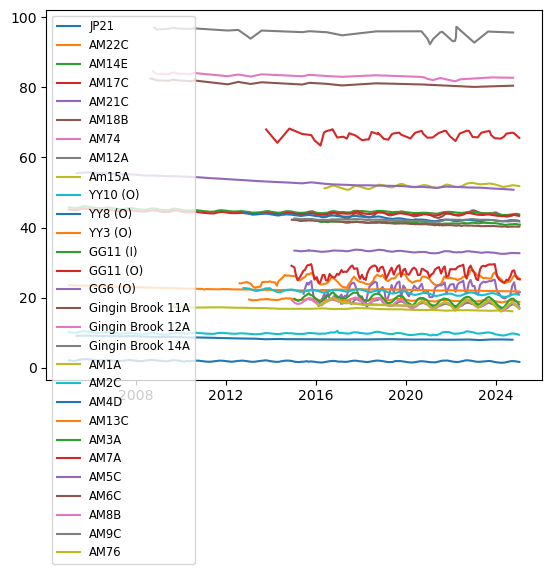

In [83]:
# Plot water levels - Leederville
leed_df = filtered_df[filtered_df['Aquifer Name'] == 'Perth-Leederville']
leed_bores = leed_df['Site Ref'].unique()

for bore in leed_bores:
    df = leed_df[leed_df['Site Ref'] == bore]
    plt.plot(df['Collect Date'], df['Reading Value'], label = df['Site Short Name'].iloc[0])
plt.legend(loc = 'upper left',fontsize = 'small', markerscale=0.5)


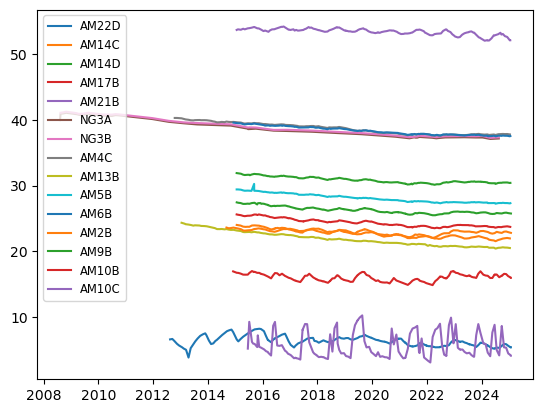

In [82]:
# Plot water levels - Yarragadee
yarr_df = filtered_df[filtered_df['Aquifer Name'] == 'Perth-Yarragadee North']
yarr_bores = yarr_df['Site Ref'].unique()

for bore in yarr_bores:
    df = yarr_df[yarr_df['Site Ref'] == bore]
    plt.plot(df['Collect Date'], df['Reading Value'], label = df['Site Short Name'].iloc[0])
plt.legend(loc = 'upper left',fontsize = 'small', markerscale=0.5)


In [ ]:
from process_observations import Observations
observations = Observations()
observations.process_obs(spatial, geomodel, mesh)

AttributeError: 'GeoDataFrame' object has no attribute 'zobs_mbgl'

### 8. Create and run steady-state flow model

In [104]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'

scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
fm.lith = geomodel.lith
fm.logk11 = geomodel.logk11
fm.logk33 = geomodel.logk33
len(fm.lith.flatten())

77246

In [ ]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = False, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
   Time taken to write flow model =  32.323608
Running simulation for  steadymodel  ...
Model success =  False
   run_time =  3.568484
   Re-writing IMS - Take 2
Model success2 =  False
   Re-writing IMS - Take 3
Model success3 =  False


In [ ]:
obj = fmss
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

In [ ]:
import plotting_routines

#vmin, vmax = min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, fmss, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, fmss, array, X0, X1, Y0, Y1)#, vmin, vmax)

### 9. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fmss.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 10. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 11. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  

In [ ]:
def print_object_details(obj):
    all_attributes_methods = dir(obj)
    methods = [attr for attr in all_attributes_methods if callable(getattr(obj, attr)) and not attr.startswith("__")]
    variables = [attr for attr in all_attributes_methods if not callable(getattr(obj, attr)) and not attr.startswith("__")]

    print('Methods:')
    for method in methods: print(method)
    print("\nVariables")
    for variable in variables: print(variable)

In [ ]:
from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.3, allow_holes = True)#False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

unique_surf_liths = np.unique(geomodel.surf_lith)

def smooth_polygons(polygon, buffer_distance=0.001):
    return polygon.buffer(buffer_distance).buffer(-buffer_distance)
def is_even(number):
    return number % 2 == 0

polygons = []
for i, lith in enumerate(unique_surf_liths):
    if not is_even(i): # only create polygons for even lithologies so boundaries dont overlap
        gdf, hull_gdf = create_surfacegeo_polys(geomodel, lith)
        gs = hull_gdf.geometry.apply(lambda geom: shape(geom))
        print(type(gs))
        print(gs)
        smoothed_gs = gs.apply(smooth_polygons)
        for smoothed_poly in smoothed_gs:
            polygons.append(smoothed_poly)
    

    fig, ax = plt.subplots()
    ax.set_title('Lithology' + str(lith))
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.show()

lith_boundaries_gdf = gpd.GeoDataFrame(geometry=polygons)
fig, ax = plt.subplots()
ax.set_title('Lithology boundaries')
lith_boundaries_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
plt.show()
    


In [ ]:
#def create_fine_grid(X, Y, num_points=500):
#    x_fine = np.linspace(X.min(), X.max(), num_points)
#    y_fine = np.linspace(Y.min(), Y.max(), num_points)
#    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
#    return X_fine, Y_fine
#
#def interpolate_data(X, Y, Z, X_fine, Y_fine):
#    from scipy.interpolate import griddata
#    Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')
#    return Z_fine

#def plot_smooth_contours(X_fine, Y_fine, Z_fine, levels=10):
#    plt.figure(figsize=(8, 6))
#    contour = plt.contour(X_fine, Y_fine, Z_fine, levels=levels, cmap='viridis')
#    plt.colorbar(contour)
#    plt.title('Smooth Contour Lines')
#    plt.xlabel('X')
#    plt.ylabel('Y')
#    plt.show()
#    return contour

def plot_contours(X, Y, Z, levels=10):
    plt.figure(figsize=(8, 6))
    contour = plt.contour(X, Y, Z, levels=levels, cmap='viridis')
    plt.colorbar(contour)
    plt.title('Contour Lines')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return contour

def extract_contour_lines(contour):
    contour_lines = []
    for collection in contour.collections:
        for path in collection.get_paths():
            v = path.vertices
            contour_lines.append(LineString(v))
    return contour_lines

def save_contour_lines_to_shapefile(contour_lines, filename):
    gdf = gpd.GeoDataFrame(geometry=contour_lines)
    gdf.to_file(filename)


#X_fine, Y_fine = create_fine_grid(X, Y)
#Z_fine = interpolate_data(X, Y, Z, X_fine, Y_fine)
#plt.imshow(Z_fine)
#levels =[-0.09, 0.01, 1.01, 2.01, 3.01, 4.01,]
X, Y = mesh.xcenters, mesh.ycenters
Z = geomodel.surf_lith.reshape(mesh.nrow, mesh.ncol)
contour = plot_contours(X, Y, Z, levels =levels)
contour_lines = extract_contour_lines(contour)
save_contour_lines_to_shapefile(contour_lines, "contour_lines.shp")